# Titanic Dataset - Feature Engineering

**Student:** Arthur Gislon Leonida

**Objective:** This dataset aims to predict the survival of passengers on the Titanic.

**Dataset URL:** https://www.kaggle.com/competitions/titanic

**Data Dictionary:**

* **survival:** Survival (0 = No, 1 = Yes) - That's the **TARGET**

* **pclass:** Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd)

* **sex:** Sex	

* **Age:** Age in years	

* **sibsp:** # of siblings / spouses aboard the Titanic	

* **parch:** # of parents / children aboard the Titanic	

* **ticket:**	Ticket number	

* **fare:** Passenger fare	

* **cabin:** Cabin number	

* **embarked:** Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

In [8]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import shap
import ipykernel
from scipy.stats import boxcox
from helper_functions import adaptive_binning, robust_outlier_detection, mutual_information, hsic

print("pandas version:", pd.__version__)
print("matplotlib version:", plt.matplotlib.__version__)
print("seaborn version:", sns.__version__)
print("sklearn version:", sklearn.__version__)
print("xgboost version:", xgb.__version__)
print("numpy version:", np.__version__)
print("shap version:", shap.__version__)
print("ipykernel version:", ipykernel.__version__)
print('python version:', os.popen('python --version').read().strip())

pandas version: 2.3.2
matplotlib version: 3.10.5
seaborn version: 0.13.2
sklearn version: 1.7.1
xgboost version: 3.0.4
numpy version: 2.2.0
shap version: 0.48.0
ipykernel version: 6.30.1
python version: Python 3.13.7


In [9]:
features_description = {
    'PassengerId': 'Passenger ID',
    'Survived': 'Survival (0 = No; 1 = Yes)',
    'Pclass': 'Passenger Class (1st, 2nd, 3rd)',
    'Name': 'Passenger Name',
    'Sex': 'Gender',
    'Age': 'Age in years',
    'SibSp': 'Number of Siblings/Spouses Aboard',
    'Parch': 'Number of Parents/Children Aboard',
    'Ticket': 'Ticket Number',
    'Fare': 'Passenger Fare',
    'Cabin': 'Cabin Number',
    'Embarked': 'Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)'
}

In [10]:
# The downloaded dataset has a file named 'Salary Prediction of Data Professions.csv'
train_file_path = 'data/train.csv'
# test_file_path = 'data/test.csv'

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(train_file_path)
df_train, df_val = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Survived'])


# I won't use this because it doesn't have the target variable (it was made for kaggle competition)
# test_df = pd.read_csv(test_file_path)

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [11]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

## Baseline Model

In [ ]:
df_baseline = df_train.copy()

# Calculate statistics from TRAINING data only
train_age_median = df_baseline['Age'].median()
train_embarked_mode = df_baseline['Embarked'].mode()[0]

# Apply to training set
df_baseline['Age'] = df_baseline['Age'].fillna(train_age_median)
df_baseline['Embarked'] = df_baseline['Embarked'].fillna(train_embarked_mode)
df_baseline['Sex'] = df_baseline['Sex'].map({'male': 0, 'female': 1})
df_baseline = pd.get_dummies(df_baseline, columns=['Embarked'], prefix='Emb', drop_first=True)

# Handle remaining object columns
for col in df_baseline.select_dtypes(include=['object']).columns:
    df_baseline[col] = df_baseline[col].astype('category').cat.codes

X_train_base = df_baseline.drop('Survived', axis=1)
y_train_base = df_baseline['Survived']

# Train model
baseline_model = xgb.XGBClassifier(random_state=42, eval_metric='logloss')
baseline_model.fit(X_train_base, y_train_base)

# Apply SAME preprocessing to validation (using training statistics)
df_val_base = df_val.copy()
df_val_base['Age'] = df_val_base['Age'].fillna(train_age_median)  # Use train median
df_val_base['Embarked'] = df_val_base['Embarked'].fillna(train_embarked_mode)  # Use train mode
df_val_base['Sex'] = df_val_base['Sex'].map({'male': 0, 'female': 1})
df_val_base = pd.get_dummies(df_val_base, columns=['Embarked'], prefix='Emb', drop_first=True)

# Handle object columns the same way
for col in df_val_base.select_dtypes(include=['object']).columns:
    df_val_base[col] = df_val_base[col].astype('category').cat.codes

X_val_base = df_val_base.drop('Survived', axis=1)
y_val_base = df_val_base['Survived']

# Evaluate
preds_base = baseline_model.predict(X_val_base)
baseline_accuracy = accuracy_score(y_val_base, preds_base)
print(f"Clean Baseline Accuracy: {baseline_accuracy:.4f}")

Clean Baseline Accuracy: 0.7039
Training columns: ['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Emb_Q', 'Emb_S']
Validation columns: ['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Emb_Q', 'Emb_S']
Columns match: True


In [13]:
df_baseline.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Emb_Q          0
Emb_S          0
dtype: int64

# FEATURE ENGINEERING PIPELINE

In [14]:
df_eng = df_baseline.copy()
df_eng = df_eng.drop('PassengerId', axis=1)

# 1. Prepare data for the k-NN model
df_eng['Deck'] = df_eng['Cabin'].str[0]
# Select features to predict the Deck
imputation_features = ['Pclass', 'Fare_log', 'FamilySize', 'Age', 'Sex', 'Title']

# 2. Separate data into a set with known decks and a set with unknown decks
train_impute = df_eng[df_eng['Deck'].notna()]
predict_impute = df_eng[df_eng['Deck'].isna()]

X_impute_train = train_impute[imputation_features]
y_impute_train = train_impute['Deck']
X_impute_predict = predict_impute[imputation_features]

# 3. Train the k-NN classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_impute_train, y_impute_train)

# 4. Predict the missing Deck values
predicted_decks = knn.predict(X_impute_predict)

# 5. Fill the missing values in your original engineered DataFrame
# We use .loc to ensure we're modifying the correct rows
df_eng.loc[df_eng['Cabin'].isna(), 'Deck'] = predicted_decks

df_val_eng['Deck'] = df_val_eng['Cabin'].str[0].fillna('U')

print("Missing Cabin Decks imputed using k-NN.")

df_eng.head()

AttributeError: Can only use .str accessor with string values!

In [ ]:
features = df_eng.drop(['Survived'], axis=1)
features.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Emb_Q,Emb_S
0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,False,True
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,False,False
2,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,False,True
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,False,True
4,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,False,True


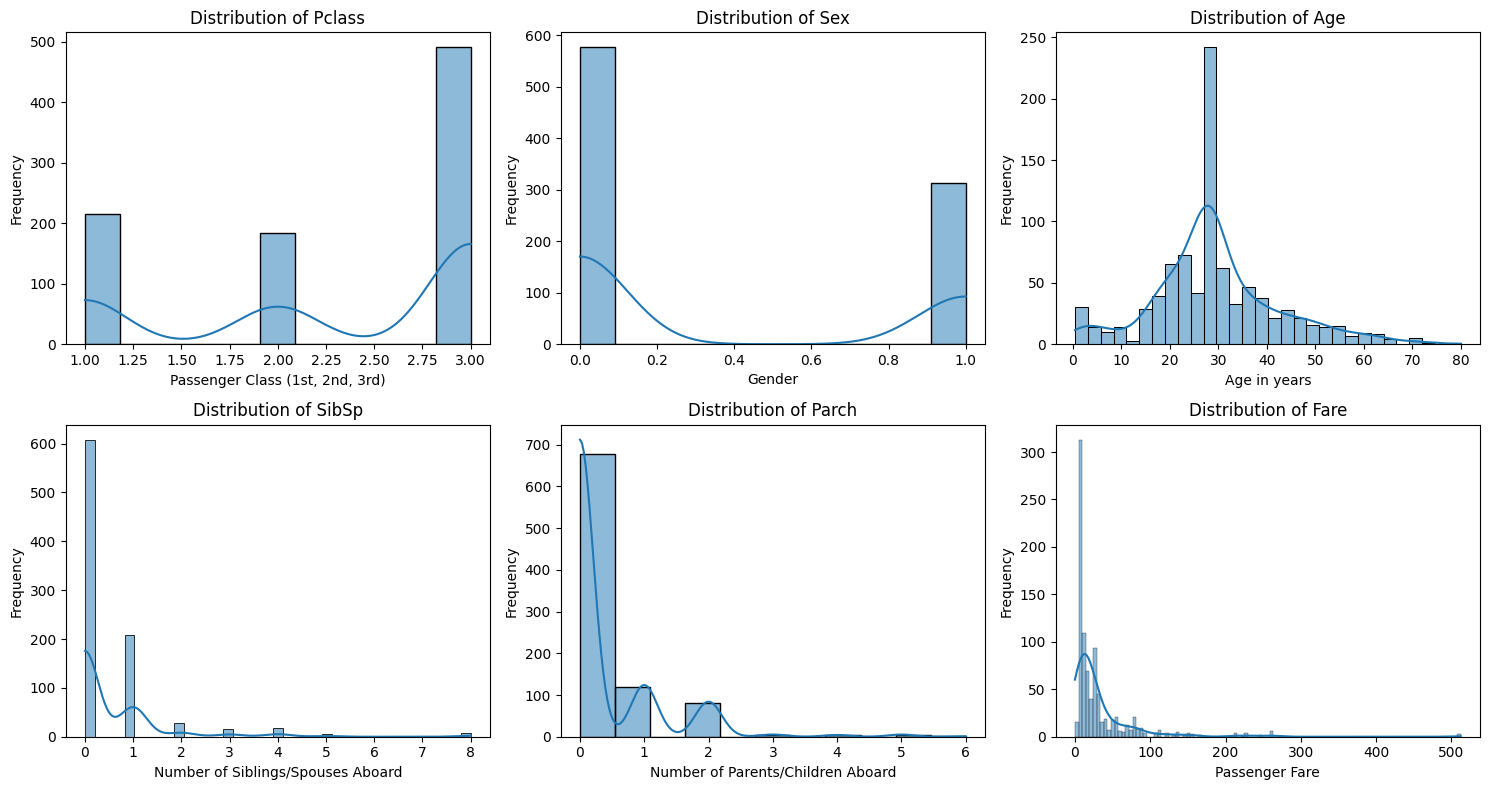

In [ ]:
numeric_features = features.select_dtypes(include=['number']).columns
num_plots = len(numeric_features)
cols = 3
rows = (num_plots + cols - 1) // cols

plt.figure(figsize=(5 * cols, 4 * rows))

for i, feature in enumerate(numeric_features):
    plt.subplot(rows, cols, i + 1)
    sns.histplot(df_eng[feature].dropna(), kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(features_description.get(feature, feature))
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
features_to_log_transform = ['Fare', 'SibSp', 'Parch']

df_eng = df.copy()

for feature in features_to_log_transform:
    df_eng[feature] = df_eng[feature].apply(lambda x: np.log1p(x) if x >= 0 else x)

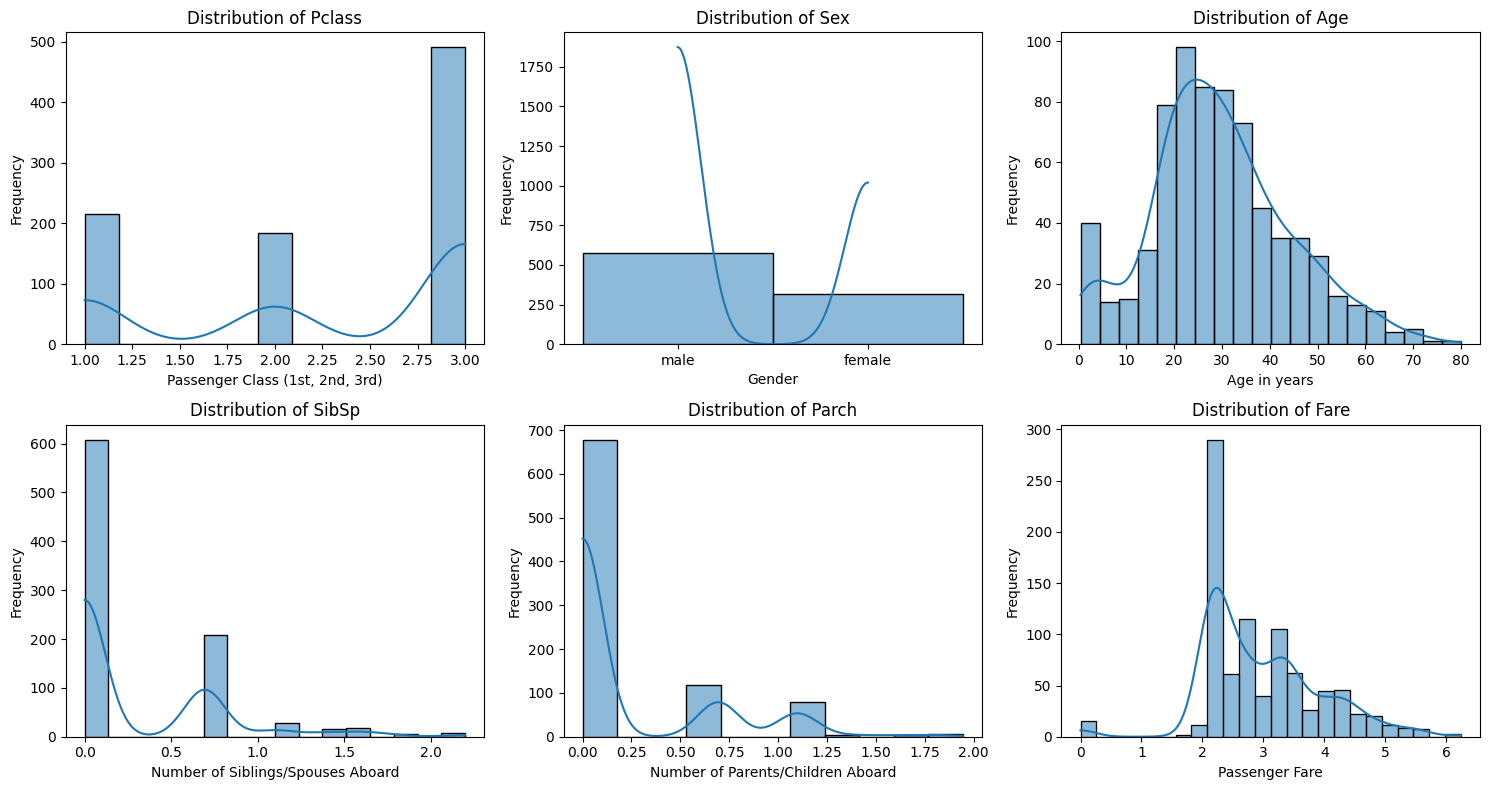

In [ ]:
plt.figure(figsize=(5 * cols, 4 * rows))

for i, feature in enumerate(numeric_features):
    plt.subplot(rows, cols, i + 1)
    sns.histplot(df_eng[feature].dropna(), kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(features_description.get(feature, feature))
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
for feature in df_eng.drop('Survived', axis=1).select_dtypes(include=['number']).columns:
    print(f"Processing feature: {feature}")
    outliers = robust_outlier_detection(df_eng[feature])
    num_outliers = outliers.sum()
    if num_outliers > 0:
        print(f'Feature "{feature}" has {num_outliers} outliers detected.')

Processing feature: PassengerId
Processing feature: Pclass
Processing feature: Age
Feature "Age" has 2 outliers detected.
Processing feature: SibSp
Feature "SibSp" has 12 outliers detected.
Processing feature: Parch
Feature "Parch" has 10 outliers detected.
Processing feature: Fare
Feature "Fare" has 18 outliers detected.


Capping outliers in "SibSp" between 0.00 and 1.39
Capping outliers in "Fare" between 2.11 and 4.73


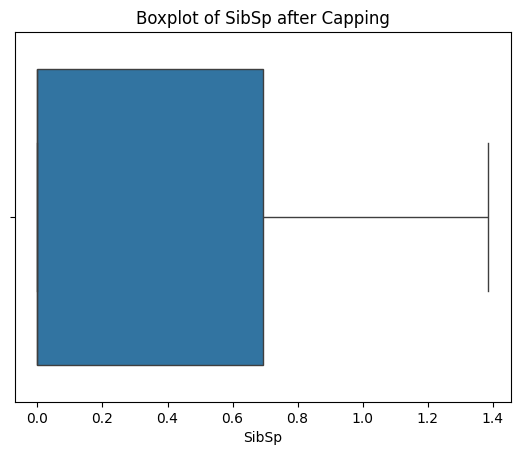

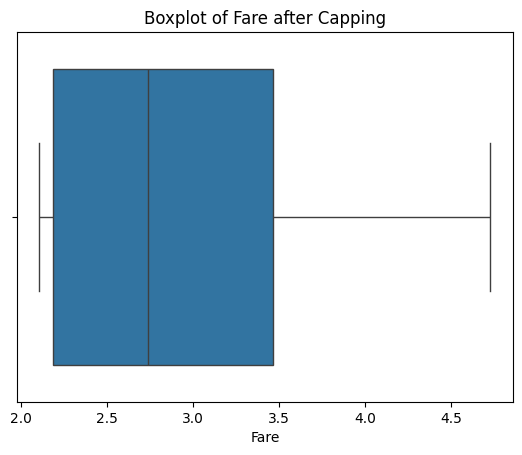

In [ ]:
# Focus on the true numerical/continuous features from the list.
features_to_cap = [ 
    'SibSp',  
    'Fare'
]

for feature in features_to_cap:
    if feature in df_eng.columns:
        # Define the lower and upper bounds for capping
        lower_bound = df_eng[feature].quantile(0.05)
        upper_bound = df_eng[feature].quantile(0.95)
        
        print(f'Capping outliers in "{feature}" between {lower_bound:.2f} and {upper_bound:.2f}')
        
        # Use np.clip to cap the values
        df_eng[feature] = np.clip(df_eng[feature], lower_bound, upper_bound)

for feature in features_to_cap:
    sns.boxplot(x=df_eng[feature])
    plt.title(f'Boxplot of {feature} after Capping')
    plt.show()

Consolidate all feature engineering into a single, reusable function.


In [ ]:
def feature_engineer_complete(df, train_median_age, train_mode_embarked):
    df_eng = df.copy()

    # Imputation
    df_eng['Age'] = df_eng['Age'].fillna(train_median_age)
    df_eng['Embarked'] = df_eng['Embarked'].fillna(train_mode_embarked)
    df_eng['Fare'] = df_eng['Fare'].fillna(df_eng['Fare'].median())

    # Basic Features
    df_eng['FamilySize'] = df_eng['SibSp'] + df_eng['Parch'] + 1
    df_eng['IsAlone'] = (df_eng['FamilySize'] == 1).astype(int)
    df_eng['Title'] = df_eng['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False).apply(lambda x: x if x in ['Mr', 'Miss', 'Mrs', 'Master'] else 'Other')
    df_eng['Deck'] = df_eng['Cabin'].str[0].fillna('U')

    # Transformations (abs, max)
    df_eng['Fare_from_mean'] = abs(df_eng['Fare'] - df_eng['Fare'].mean())
    df_eng['Max_SibSp_Parch'] = df_eng[['SibSp', 'Parch']].max(axis=1) # maximum value between the number of siblings/spouses (SibSp) and the number of parents/children (Parch) aboard for each passenger
    df_eng['Age*Pclass'] = df_eng['Age'] * df_eng['Pclass'] # capture interaction between age and passenger class
    
    # *** USE YOUR ADAPTIVE BINNING FUNCTION ***
    features_to_bin = ['Age', 'Fare', 'FamilySize', 'SibSp', 'Parch', 
                       'Fare_from_mean', 'Max_SibSp_Parch', 'Age*Pclass']
    binned_columns = []
    for feature in features_to_bin:
        if feature in df_eng.columns:
            # Get optimal bin number using your adaptive function
            optimal_bins = adaptive_binning(df_eng[feature])
            
            # Create the new binned column name
            binned_col_name = f'{feature}_binned'
            
            # Create the binned feature
            df_eng[binned_col_name] = pd.cut(df_eng[feature], bins=optimal_bins, labels=False, duplicates='drop')
            binned_columns.append(binned_col_name)
            print(f"Binned '{feature}' into {optimal_bins} bins.")

    columns_to_encode = ['Sex', 'Embarked', 'Deck', 'Title'] + binned_columns
    df_eng = pd.get_dummies(df_eng, columns=columns_to_encode, drop_first=True)
    
    # Define all original and intermediate columns to be dropped
    columns_to_drop = [
        'PassengerId', 'Name', 'Ticket', 'Cabin', 'Fare', 'FamilySize', 'Age',
        'SibSp', 'Parch', 'Fare_from_mean', 'Max_SibSp_Parch', 'Age*Pclass'
    ]
    df_eng.drop(columns=columns_to_drop, inplace=True, errors='ignore')
    
    return df_eng

In [ ]:
df_eng = df_eng.drop(['PassengerId'], axis=1)
df_eng.head(5)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,0.693147,0.0,A/5 21171,2.110213,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,0.693147,0.0,PC 17599,4.280593,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0.000000,0.0,STON/O2. 3101282,2.188856,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,0.693147,0.0,113803,3.990834,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0.000000,0.0,373450,2.202765,NaN,S


In [ ]:
# Now apply the full pipeline
df_eng = feature_engineer_complete(df_eng, df_eng['Age'].median(), df_eng['Embarked'].mode()[0])

Binned 'Age' into 2 bins.
Binned 'Fare' into 2 bins.
Binned 'FamilySize' into 2 bins.
Binned 'SibSp' into 4 bins.
Binned 'Parch' into 7 bins.
Binned 'Fare_from_mean' into 2 bins.
Binned 'Max_SibSp_Parch' into 7 bins.
Binned 'Age*Pclass' into 2 bins.


In [ ]:
df_eng.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   Survived                  891 non-null    int64
 1   Pclass                    891 non-null    int64
 2   IsAlone                   891 non-null    int64
 3   Sex_male                  891 non-null    bool 
 4   Embarked_Q                891 non-null    bool 
 5   Embarked_S                891 non-null    bool 
 6   Deck_B                    891 non-null    bool 
 7   Deck_C                    891 non-null    bool 
 8   Deck_D                    891 non-null    bool 
 9   Deck_E                    891 non-null    bool 
 10  Deck_F                    891 non-null    bool 
 11  Deck_G                    891 non-null    bool 
 12  Deck_T                    891 non-null    bool 
 13  Deck_U                    891 non-null    bool 
 14  Title_Miss                891 non-null    

## Why the code below is necessary:

* When I use pd.get_dummies (one-hot encoding) on my training and validation sets separately, they might end up with a different number of columns.

* Example: if a rare Title like 'Dr' only appears in my training data, the Title_Dr column will be created in X_train_eng but not in X_val_eng.

In [ ]:
# === Align Columns After Feature Engineering ===

# Identify the columns from the fully engineered training set
train_cols = X_train_eng.columns
val_cols = X_val_eng.columns

# Find columns that are in the training set but not in the validation set
# This can happen if a certain category (e.g., a rare 'Title' or 'Deck') 
# exists in the training data but not in the validation split.
missing_in_val = set(train_cols) - set(val_cols)

# Add the missing columns to the validation set and fill them with 0
for c in missing_in_val:
    X_val_eng[c] = 0
    print(f"Added missing column to validation set: {c}")

# Find columns that are in the validation set but not in the training set
# This is rarer but can happen with certain data splits.
missing_in_train = set(val_cols) - set(train_cols)
for c in missing_in_train:
    # We would drop these from the validation set as the model has never seen them
    X_val_eng.drop(c, axis=1, inplace=True)
    print(f"Dropped extra column from validation set: {c}")


# Ensure the order of columns in the validation set is identical to the training set
X_val_eng = X_val_eng[train_cols]

print("\nColumn alignment complete.")

NameError: name 'X_train_eng' is not defined

## Feature Selection

In [ ]:
df_selection = X_train_eng.copy()
y_selection = y_train_eng.copy()

# Calculate scores
mi_scores = df_selection.apply(lambda x: mutual_information(x, y_selection), axis=0)
hsic_scores = df_selection.apply(lambda x: hsic(x, y_selection), axis=0)

# Select top-k features
scores_df = pd.DataFrame({'MI': mi_scores, 'HSIC': hsic_scores}).sort_values(by='MI', ascending=False)
k = 20
top_mi = scores_df['MI'].nlargest(k).index
top_hsic = scores_df['HSIC'].nlargest(k).index
final_features = list(set(top_mi) | set(top_hsic))
print(f"Selected {len(final_features)} features after voting:")
print(final_features)

Selected 21 features after voting:
['Age*Pclass_binned_1', 'FamilySize_binned_1', 'Deck_C', 'Deck_E', 'Max_SibSp_Parch_binned_1', 'IsAlone', 'Deck_U', 'Max_SibSp_Parch_binned_3', 'Deck_B', 'Deck_D', 'Embarked_S', 'Sex_male', 'Deck_F', 'FamilySize_binned_4', 'Title_Miss', 'Pclass', 'Title_Mr', 'FamilySize_binned_2', 'Title_Mrs', 'Parch_binned_2', 'Parch_binned_1']


## Final Modeling and SHAP

In [ ]:
# 1. Select the top-k features AND create an explicit copy
X_train_final = X_train_eng[final_features].copy()
y_train_final = y_train_eng.copy()

X_val_final = X_val_eng[final_features].copy()
y_val_final = y_val_eng.copy()

# 2. Convert boolean columns to integers
# This part of your code no longer needs to be changed
bool_cols = X_train_final.select_dtypes(include=['bool']).columns
if len(bool_cols) > 0:
    print(f"Converting boolean columns: {list(bool_cols)}")
    for col in bool_cols:
        X_train_final[col] = X_train_final[col].astype(int)
        X_val_final[col] = X_val_final[col].astype(int)
    print("Boolean columns converted to integers.")

X_train_final.info()

Converting boolean columns: ['Age*Pclass_binned_1', 'FamilySize_binned_1', 'Deck_C', 'Deck_E', 'Max_SibSp_Parch_binned_1', 'Deck_U', 'Max_SibSp_Parch_binned_3', 'Deck_B', 'Deck_D', 'Embarked_S', 'Sex_male', 'Deck_F', 'FamilySize_binned_4', 'Title_Miss', 'Title_Mr', 'FamilySize_binned_2', 'Title_Mrs', 'Parch_binned_2', 'Parch_binned_1']
Boolean columns converted to integers.
<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 692 to 507
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   Age*Pclass_binned_1       712 non-null    int64
 1   FamilySize_binned_1       712 non-null    int64
 2   Deck_C                    712 non-null    int64
 3   Deck_E                    712 non-null    int64
 4   Max_SibSp_Parch_binned_1  712 non-null    int64
 5   IsAlone                   712 non-null    int64
 6   Deck_U                    712 non-null    int64
 7   Max_SibSp_Parch_binned_3  712 non-null 

In [ ]:
X_train_final.head(5)

,Age*Pclass_binned_1,FamilySize_binned_1,Deck_C,Deck_E,Max_SibSp_Parch_binned_1,IsAlone,Deck_U,Max_SibSp_Parch_binned_3,Deck_B,Deck_D,...,Sex_male,Deck_F,FamilySize_binned_4,Title_Miss,Pclass,Title_Mr,FamilySize_binned_2,Title_Mrs,Parch_binned_2,Parch_binned_1
692,0,0,0,0,0,1,1,0,0,0,...,1,0,0,0,3,1,0,0,0,0
481,0,0,0,0,0,1,1,0,0,0,...,1,0,0,0,2,1,0,0,0,0
527,0,0,1,0,0,1,0,0,0,0,...,1,0,0,0,1,1,0,0,0,0
855,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,3,0,0,1,0,1
801,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,2,0,0,1,0,1



--- Model Performance Comparison ---
Baseline Model Accuracy: 0.8156
Final Model Accuracy:    0.7654
------------------------------------


c:\Users\arthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:07:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



SHAP Summary Plot (Top 15 Features):


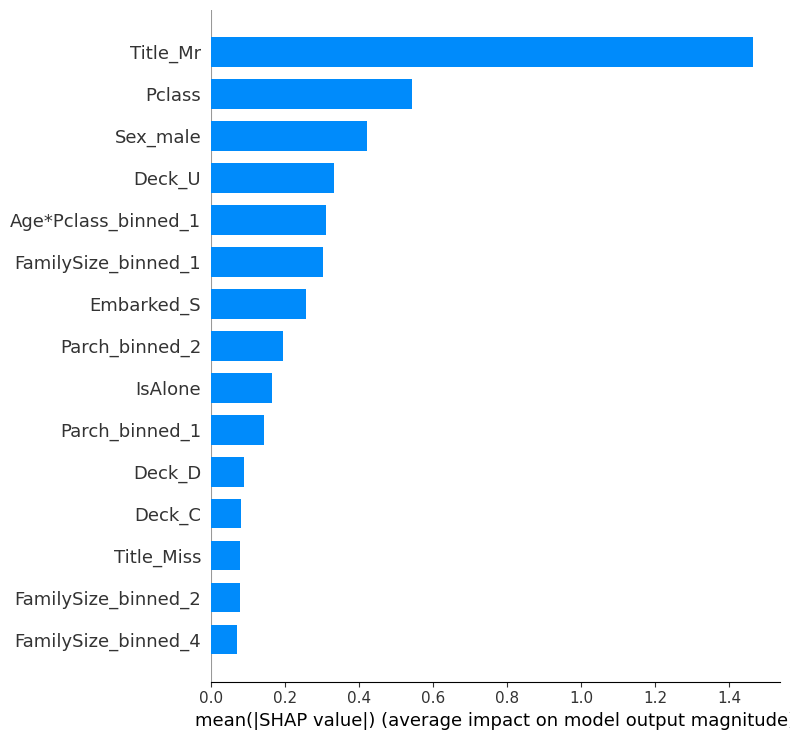

In [ ]:
final_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
'''
final_model = xgb.XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    max_depth=4,  # Limit tree depth to prevent overfitting
    gamma=0.1      # Add a regularization term
)
'''
final_model.fit(X_train_final, y_train_final)
preds_final = final_model.predict(X_val_final)
final_accuracy = accuracy_score(y_val_final, preds_final)

print("\n--- Model Performance Comparison ---")
# Make sure you have the baseline_accuracy variable from the start of your notebook
print(f"Baseline Model Accuracy: {baseline_accuracy:.4f}") 
print(f"Final Model Accuracy:    {final_accuracy:.4f}")
print("------------------------------------")

explainer = shap.Explainer(final_model, X_train_final)
shap_values = explainer(X_val_final)
print("\nSHAP Summary Plot (Top 15 Features):")
shap.summary_plot(shap_values, X_val_final, plot_type="bar", max_display=15)